In [7]:
# Import all packages needed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import json
from pathlib import Path
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [8]:
# Import style.json
style_path: Path = Path.cwd().parent / 'style' / 'style.json'
with open(style_path, 'r') as f: # opens the style.json file
    style: dict = json.load(f) # loads as a dictionary object

In [9]:
# Loading Data (data file must be in the same directory as jupyter notebook)
# Import data from excel file
# TODO: replace filename with the name of your data file
tga_raw_data_filename: str ='ExpDat_2024_01_19_SL_001G.csv'
ms_raw_data_filename: str ='ExpDat_2024_01_19_SL_001G-aeolos.csv'
tga_raw_data_filename_2: str ='ExpDat_2024_01_19_SL_005P.csv'
ms_raw_data_filename_2: str ='ExpDat_2024_01_19_SL_005P-aeolos.csv'

# Tell program to read the data
tga_raw_data: pd.DataFrame = pd.read_csv(tga_raw_data_filename, encoding="iso-8859-1", on_bad_lines='warn', skiprows=37) # read data into a pandas dataframe
ms_raw_data: pd.DataFrame = pd.read_csv(ms_raw_data_filename, encoding="iso-8859-1", on_bad_lines='skip', skiprows=28) # read data into a pandas dataframe
tga_raw_data_2: pd.DataFrame = pd.read_csv(tga_raw_data_filename_2, encoding="iso-8859-1", on_bad_lines='warn', skiprows=37) # read data into a pandas dataframe
ms_raw_data_2: pd.DataFrame = pd.read_csv(ms_raw_data_filename_2, encoding="iso-8859-1", on_bad_lines='skip', skiprows=28) # read data into a pandas dataframe
tga_sample_mass: float = float(pd.read_csv(tga_raw_data_filename, encoding="iso-8859-1", on_bad_lines='warn').loc[17,:][1])
tga_sample_mass_2: float = float(pd.read_csv(tga_raw_data_filename_2, encoding="iso-8859-1", on_bad_lines='warn').loc[17,:][1])
# print(tga_sample_mass_2)
# Output data
# tga_raw_data
# ms_raw_data
print(tga_raw_data.columns, ms_raw_data.columns)

Index(['##Temp./C', 'Time/min', 'DSC/(mW/mg)', 'Mass/%',
       'Gas Flow(purge2)/(ml/min)', 'Gas Flow(protective)/(ml/min)',
       'TIC(scan:1)/A', 'Sensit./(uV/mW)', 'Segment'],
      dtype='object') Index(['##Temp./C', 'Time/min', 'QMID(s:1|m:15)/A', 'QMID(s:1|m:16)/A',
       'QMID(s:1|m:17)/A', 'QMID(s:1|m:18)/A', 'QMID(s:1|m:19)/A',
       'QMID(s:1|m:20)/A', 'QMID(s:1|m:21)/A', 'QMID(s:1|m:22)/A',
       ...
       'QMID(s:1|m:141)/A', 'QMID(s:1|m:142)/A', 'QMID(s:1|m:143)/A',
       'QMID(s:1|m:144)/A', 'QMID(s:1|m:145)/A', 'QMID(s:1|m:146)/A',
       'QMID(s:1|m:147)/A', 'QMID(s:1|m:148)/A', 'QMID(s:1|m:149)/A',
       'QMID(s:1|m:150)/A'],
      dtype='object', length=138)


Skipping line 23: expected 2 fields, saw 3
Skipping line 39: expected 2 fields, saw 9
Skipping line 40: expected 2 fields, saw 9
Skipping line 41: expected 2 fields, saw 9
Skipping line 42: expected 2 fields, saw 9
Skipping line 43: expected 2 fields, saw 9
Skipping line 44: expected 2 fields, saw 9
Skipping line 45: expected 2 fields, saw 9
Skipping line 46: expected 2 fields, saw 9
Skipping line 47: expected 2 fields, saw 9
Skipping line 48: expected 2 fields, saw 9
Skipping line 49: expected 2 fields, saw 9
Skipping line 50: expected 2 fields, saw 9
Skipping line 51: expected 2 fields, saw 9
Skipping line 52: expected 2 fields, saw 9
Skipping line 53: expected 2 fields, saw 9
Skipping line 54: expected 2 fields, saw 9
Skipping line 55: expected 2 fields, saw 9
Skipping line 56: expected 2 fields, saw 9
Skipping line 57: expected 2 fields, saw 9
Skipping line 58: expected 2 fields, saw 9
Skipping line 59: expected 2 fields, saw 9
Skipping line 60: expected 2 fields, saw 9
Skipping li

In [10]:
# Data preprocessing specific to NETZCHE TGA-MS
#TODO: baseline correction?
# TODO: normalize as an option
def preprocess(tga_data: pd.DataFrame, ms_data: pd.DataFrame, initial_correction_time: float, sample_mass: float) -> pd.DataFrame:
    """Function that applies transformation to the dataframe which will make it ready for plotting. Note, this is specific to TGA-MS.
    """
    # Remove % sign from columns in tga_raw_data
    tga_data.columns = tga_data.columns.str.replace('%', 'pct')
    # Truncate Temp./C column to Temp
    tga_data.columns = tga_data.columns.str.replace(tga_data.columns[0], 'Temp')
    # Truncate Temp./C column to Temp in ms_raw_data
    ms_data.columns = ms_data.columns.str.replace(ms_data.columns[0], 'Temp')
    # find the row closest to the initial_correction_time for tga_data
    initial_correction_time_row: int = tga_data.iloc[(tga_data['Time/min']-initial_correction_time).abs().argsort()[:1]].index[0]
    # find the row closest to the initial correction time for ms_data
    initial_correction_time_row_ms: int = ms_data.iloc[(ms_data['Time/min']-initial_correction_time).abs().argsort()[:1]].index[0]
     # Subtract 100 from the Mass/% datapoint from the initial_correction_time_row
    correction_mass = 100 - tga_data['Mass/pct'][initial_correction_time_row]
    tga_data['Mass/pct'] = tga_data['Mass/pct'] + correction_mass
    # Normalize the mass spec data by dividing by the initial mass
    # tga_data['Mass/pct'] = tga_data['Mass/pct']*sample_mass / 100
    # Remove the rows before the initial_correction_time_row for both tga_data and ms_data
    tga_data = tga_data.iloc[initial_correction_time_row:]
    ms_data = ms_data.iloc[initial_correction_time_row_ms:]
    return tga_data, ms_data
    # return data

# NOTE: change True to False if you don't want normalization or baseline correction
preprocessed_data: (pd.DataFrame, pd.DataFrame) = preprocess(tga_raw_data, ms_raw_data, 30, tga_sample_mass)
preprocessed_data_2: (pd.DataFrame, pd.DataFrame) = preprocess(tga_raw_data_2, ms_raw_data_2, 30, tga_sample_mass_2)
preprocessed_data[1].head()

,Temp,Time/min,QMID(s:1|m:15)/A,QMID(s:1|m:16)/A,QMID(s:1|m:17)/A,QMID(s:1|m:18)/A,QMID(s:1|m:19)/A,QMID(s:1|m:20)/A,QMID(s:1|m:21)/A,QMID(s:1|m:22)/A,...,QMID(s:1|m:141)/A,QMID(s:1|m:142)/A,QMID(s:1|m:143)/A,QMID(s:1|m:144)/A,QMID(s:1|m:145)/A,QMID(s:1|m:146)/A,QMID(s:1|m:147)/A,QMID(s:1|m:148)/A,QMID(s:1|m:149)/A,QMID(s:1|m:150)/A
169,217.34900,30.04260,7.744462e-12,6.470963e-10,3.308779e-11,1.587917e-10,8.315086e-12,7.024866e-09,2.461910e-13,5.082804e-13,...,1.341915e-13,1.112652e-13,1.970196e-13,6.239891e-14,7.430077e-14,2.505302e-14,4.822731e-14,5.085945e-14,5.595207e-14,1.017475e-13
170,219.42300,30.21812,7.857377e-12,6.431442e-10,3.350359e-11,1.590549e-10,8.381843e-12,7.041842e-09,2.231693e-13,5.518252e-13,...,1.460171e-13,1.062870e-13,2.450848e-13,3.829002e-14,1.026630e-13,3.531456e-14,5.581856e-14,4.372597e-14,4.422188e-14,9.272575e-14
171,221.10600,30.39472,7.709596e-12,6.387554e-10,3.384119e-11,1.590263e-10,8.507728e-12,7.055193e-09,2.279758e-13,5.065638e-13,...,1.300716e-13,1.003742e-13,1.968861e-13,7.790565e-14,6.810188e-14,4.059792e-14,5.688667e-14,6.609916e-14,4.748344e-14,8.446693e-14
172,223.15401,30.57511,7.600152e-12,6.344639e-10,3.375727e-11,1.573936e-10,8.522987e-12,7.057673e-09,2.403355e-13,5.509287e-13,...,9.335518e-14,8.625984e-14,2.243137e-13,7.763863e-14,8.809090e-14,5.541801e-14,4.916191e-14,6.928444e-14,4.633903e-14,8.347511e-14
173,225.36000,30.75527,7.633665e-12,6.288296e-10,3.348833e-11,1.582538e-10,8.448600e-12,7.062632e-09,2.455044e-13,4.935366e-13,...,1.618481e-13,9.789467e-14,1.796436e-13,6.817818e-14,8.984566e-14,5.602837e-14,6.550789e-14,4.677773e-14,4.008293e-14,1.072407e-13


Text(0, 0.5, 'Ion Count')

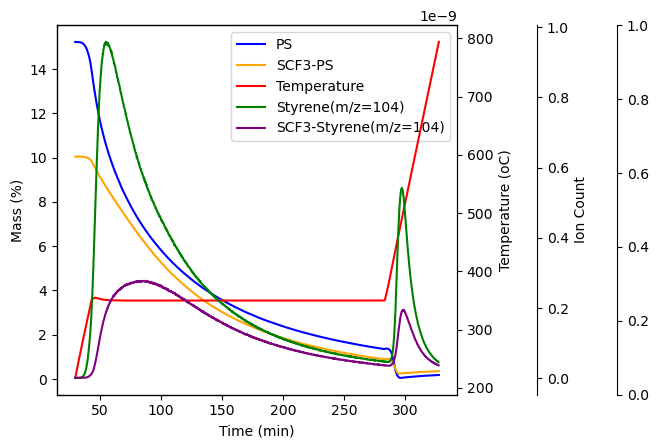

In [11]:
# Mass loss (y-axis) vs time (x-axis) plot of the TGA data
fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin3 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.2))
twin3.spines.right.set_position(("axes", 1.4))

p1 = ax.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['Mass/pct'], color="b", label='PS')
p2 = twin1.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['Temp'], color="r", label='Temperature')
p3 = twin2.plot(preprocessed_data[1]['Time/min'], preprocessed_data[1]['QMID(s:1|m:104)/A'], color="g", label='Styrene(m/z=104)')
# p4 = twin3.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['TIC(scan:1)/A'], color="y", label='Total Ion Count')

p1 = ax.plot(preprocessed_data_2[0]['Time/min'], preprocessed_data_2[0]['Mass/pct'], color="orange", label='SCF3-PS')
p3 = twin2.plot(preprocessed_data_2[1]['Time/min'], preprocessed_data_2[1]['QMID(s:1|m:104)/A'], color="purple", label='SCF3-Styrene(m/z=104)')
# p4 = twin3.plot(preprocessed_data_2[0]['Time/min'], preprocessed_data_2[0]['TIC(scan:1)/A'], color="y", label='Total Ion Count')

# Create a legend for all the lines
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = twin1.get_legend_handles_labels()
lines3, labels3 = twin2.get_legend_handles_labels()
# lines4, labels4 = twin3.get_legend_handles_labels()
ax.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc=0)

# Set x and y axis labels
ax.set_xlabel('Time (min)')
ax.set_ylabel('Mass (%)')
twin1.set_ylabel('Temperature (oC)')
twin2.set_ylabel('Ion Count')

# Set colors for the axis labels



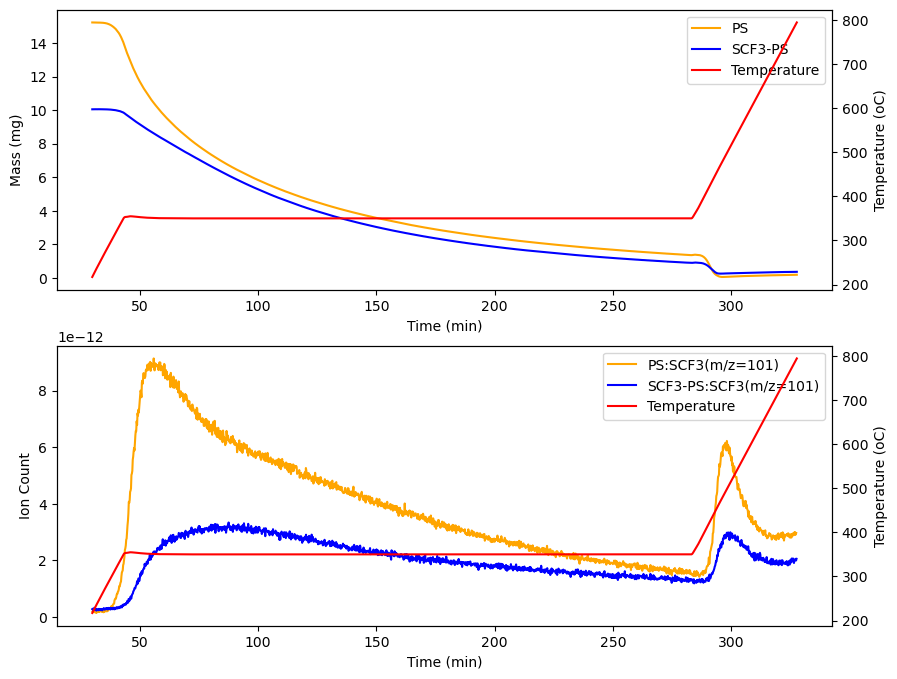

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# TGA data subplot
twin1 = ax1.twinx()
ax1.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['Mass/pct'], color="orange", label='PS')
ax1.plot(preprocessed_data_2[0]['Time/min'], preprocessed_data_2[0]['Mass/pct'], color="b", label='SCF3-PS')
twin1.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['Temp'], color="red", label='Temperature')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Mass (%)')
twin1.set_ylabel('Temperature (oC)')
# Create a legend for all the lines
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = twin1.get_legend_handles_labels()
# lines4, labels4 = twin3.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0)

# MS data subplot
twin2 = ax2.twinx()
# twin3 = ax2.twinx()
# twin3.spines.right.set_position(("axes", 1.1))
# ax2.plot(preprocessed_data[1]['Time/min'], preprocessed_data[1]['QMID(s:1|m:104)/A'], color="orange", label='PS:Styrene(m/z=104)')
# ax2.plot(preprocessed_data_2[1]['Time/min'], preprocessed_data_2[1]['QMID(s:1|m:104)/A'], color="b", label='SCF3-PS:Styrene(m/z=104)')
ax2.plot(preprocessed_data[1]['Time/min'], preprocessed_data[1]['QMID(s:1|m:101)/A'], color="orange", label='PS:SCF3(m/z=101)')
ax2.plot(preprocessed_data_2[1]['Time/min'], preprocessed_data_2[1]['QMID(s:1|m:101)/A'], color="blue", label='SCF3-PS:SCF3(m/z=101)')
# twin3.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['TIC(scan:1)/A'], color="orange", label='PS:TIC')
# twin3.plot(preprocessed_data_2[0]['Time/min'], preprocessed_data_2[0]['TIC(scan:1)/A'], color="blue", label='SCF3-PS:TIC')
twin2.plot(preprocessed_data[0]['Time/min'], preprocessed_data[0]['Temp'], color="red", label='Temperature')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Ion Count')
twin2.set_ylabel('Temperature (oC)')
twin3.set_ylabel('Total Ion Count')
# Create a legend for all the lines
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = twin2.get_legend_handles_labels()
# lines3, labels3 = twin3.get_legend_handles_labels()
# lines4, labels4 = twin3.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
# ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc=0)

# plt.tight_layout()
# plt.show()

plt.savefig("TGA_isothermal_005P_vs_001G.svg", dpi=300, bbox_inches="tight")
plt.savefig("TGA_isothermal_005P_vs_001G.jpg", dpi=300, bbox_inches="tight")